# Intent Classification using Pytorch
## Creating three different deep learning models to perform simple intent classification
### the models used are ANN, BiLSTM and BERT.

In this notebook I will perform intent classification on the ATIS data set. Info about the dataset can be read [here](https://paperswithcode.com/dataset/atis). The dataset I used is provided in github along with this notebook.





$\alpha$ : Build an intent classification model which is NOT based on a language model

$\beta$ : Build an intent classification model which is based on a language model

In this notebook I will perform Intent classification using the following models:
* Naive ANN ($\alpha$)
* Bidirectional LSTM ($\beta$)
* BERT (transfer learning + fine tuning) ($\beta$)

This notebook contains most of my thought process. I hope it is understandable.

The book Deep Learning by Goodfellow, Bengio & Courville states: "A language model defines a probability distribution
    over sequences of tokens in a natural language" 

Additionally, according to [Stanford CS224n lecture 6](https://www.youtube.com/watch?v=iWea12EAu6U)
    A Language model is the task of predicting what word comes next. In other words, given a sequence of words $x_1, x_2,....x_t$ we want to calculate the (conditional) probability distribution of the next $x_{t+1}$ where $x_{t+1}$ can be any word in the vocabulary $V$.
    
From this and from the Deep Learning book, I come to the conclusion that for $\alpha$ I must see each word of a given sentence as a FEATURE and perform regression(multi class logistic). I need to see each word as a feature where its location in the sentence is not important. The point is to compare a language model such as BERT and LSTM to a naive non-language model
such as a fully connected, multi layer neural network.

Before Starting with the models, I need to upload the data and do some text preprocessing. Because Deep learning models work with numbers.

From inspecting the data, i can see that each sentence in the "Seq.in" there is a single sentence/row as a label
So for example "i want to fly to baltimore..."  should have the label "atis_flight". This really feels like I should be using some kind of 
cross entropy loss.

#### Preprocessing:

In this step i will upload the data make it readable and understandable and then make it possible for input into 
a PyTorch Deep Learning Model.
After this step I will be able to create the models quite easily to train and test them.


Uploading:

In [1]:
import pandas as pd
import numpy as np

In [2]:
## trainseq, train_label, testseq, testlabel <-- names of the new data
## i changed the names of the original data to make it clearer for me on my laptop.

In [3]:
trainseq=pd.read_csv('trainseq.in',header=None)
train_label=pd.read_csv('train_label',header=None)
testseq=pd.read_csv('testseq.in',header=None)
test_label=pd.read_csv('testlabel',header=None)
### just printing to make sure all is good.
trainseq,train_label,testseq,test_label

(                                                      0
 0     i want to fly from baltimore to dallas round trip
 1     round trip fares from baltimore to philadelphi...
 2     show me the flights arriving on baltimore on j...
 3     what are the flights which depart from san fra...
 4     which airlines fly from boston to washington d...
 ...                                                 ...
 4473  what's the first flight after 1 pm leaving was...
 4474  what are the nonstop flights on america west o...
 4475  tell me about ground transportation between or...
 4476  i'd like a twa flight from las vegas to new yo...
 4477  is there a delta flight from denver to san fra...
 
 [4478 rows x 1 columns],
                         0
 0             atis_flight
 1            atis_airfare
 2             atis_flight
 3             atis_flight
 4            atis_airline
 ...                   ...
 4473          atis_flight
 4474          atis_flight
 4475  atis_ground_service
 4476          ati

Some exploration of the data:

In [4]:
trainseq.iloc[3,0], train_label.iloc[3,0]

('what are the flights which depart from san francisco fly to washington via indianapolis and arrive by 9 pm',
 'atis_flight')

In [5]:
train_label[0].nunique(), train_label[0].unique()

(21,
 array(['atis_flight', 'atis_airfare', 'atis_airline',
        'atis_ground_service', 'atis_quantity', 'atis_city',
        'atis_flight#atis_airfare', 'atis_abbreviation', 'atis_aircraft',
        'atis_distance', 'atis_ground_fare', 'atis_capacity',
        'atis_flight_time', 'atis_meal',
        'atis_aircraft#atis_flight#atis_flight_no', 'atis_flight_no',
        'atis_restriction', 'atis_airport', 'atis_airline#atis_flight_no',
        'atis_cheapest', 'atis_ground_service#atis_ground_fare'],
       dtype=object))

In [6]:
test_label[0].nunique(), test_label[0].unique()

(20,
 array(['atis_flight', 'atis_airfare', 'atis_flight#atis_airfare',
        'atis_ground_service', 'atis_day_name', 'atis_meal',
        'atis_airport', 'atis_airline', 'atis_flight_time', 'atis_city',
        'atis_ground_fare', 'atis_quantity', 'atis_abbreviation',
        'atis_distance', 'atis_aircraft', 'atis_airfare#atis_flight',
        'atis_capacity', 'atis_flight#atis_airline',
        'atis_flight_no#atis_airline', 'atis_flight_no'], dtype=object))

My assumption is that we get a sentence, and we output a label which matches the SENTENCE. So we can see that the labelling is not ideal because there's a lot of disjoint
labels. My guess is that the '#'  symbol in the labelling stands for "and". I will try to do some fixing of the labelling and then 
I can move on to the easier preprocessing for model input.

 I think the best thing to do is to simplify the labelling. In other words, I will trim each label with "#" to be only the label
with the first word before that symbol
So for example,

* "atis_aircraft#atis_flight#atis_flight_no" will become "atis_aircraft"
* "atis_ground_service#atis_ground_fare" will become "atis_ground_service"
* 'atis_flight#atis_airfare' will become "atis_flight"
etc...



In [7]:
# this function will take the label data, and trim off the parts from # to the end of sentence, leaving us
# with just the first "real" label 
def label_fixer(label_data):
    df=label_data.copy()
    for w in range(len(df)):
        end=df.iloc[w,0].find('#')
        if end>0:
            df.iloc[w,0]=df.iloc[w,0][0:end]
    return df

#### Using the above function...
fixed_train_label=label_fixer(train_label)
fixed_test_label=label_fixer(test_label)

Now i want to find all the possible labels, so i can map them to integers and then use those integers for my model

In [8]:
# turning the labels into sets and then getting the union so we have all labels.
train_label_set=set(fixed_train_label[0])
test_label_set=set(fixed_test_label[0])
all_labels=train_label_set.union(test_label_set)
# then creating a dictionary to have the mapping, each label will have its own integer.
#print(len(all_labels) , all_labels)
all_labels_mapping=dict(zip(all_labels, range(0, len(all_labels)))) 
all_labels_mapping_reverse = {v: k for k, v in all_labels_mapping.items()} # this is the reverse of the all_labels_mapping
all_labels_mapping # <--- will be important for the rest of this question!

{'atis_aircraft': 0,
 'atis_abbreviation': 1,
 'atis_day_name': 2,
 'atis_restriction': 3,
 'atis_airfare': 4,
 'atis_capacity': 5,
 'atis_flight_no': 6,
 'atis_flight': 7,
 'atis_quantity': 8,
 'atis_ground_fare': 9,
 'atis_flight_time': 10,
 'atis_airline': 11,
 'atis_distance': 12,
 'atis_ground_service': 13,
 'atis_airport': 14,
 'atis_cheapest': 15,
 'atis_city': 16,
 'atis_meal': 17}

In [9]:
# Creating the final, main data frames for the rest of this notebook. Will be in all caps. 
# fixing up the names of columns to make everything more readable and undestandable...
trainseq=trainseq.rename(columns={0: 'data'})
testseq=testseq.rename(columns={0:'data'})
fixed_train_label=fixed_train_label.rename(columns={0:'label'})
fixed_test_label=fixed_test_label.rename(columns={0:'label'})
# creating the final dataframes:
TRAIN_DATA_FRAME=pd.concat([fixed_train_label,trainseq],axis=1)
TRAIN_DATA_FRAME['label_mapping']=TRAIN_DATA_FRAME['label'].map(all_labels_mapping)

TEST_DATA_FRAME=pd.concat([fixed_test_label,testseq],axis=1)
TEST_DATA_FRAME['label_mapping']=TEST_DATA_FRAME['label'].map(all_labels_mapping)
### "main data frame"
TRAIN_DATA_FRAME

,label,data,label_mapping
0,atis_flight,i want to fly from baltimore to dallas round trip,7
1,atis_airfare,round trip fares from baltimore to philadelphi...,4
2,atis_flight,show me the flights arriving on baltimore on j...,7
3,atis_flight,what are the flights which depart from san fra...,7
4,atis_airline,which airlines fly from boston to washington d...,11
...,...,...,...
4473,atis_flight,what's the first flight after 1 pm leaving was...,7
4474,atis_flight,what are the nonstop flights on america west o...,7
4475,atis_ground_service,tell me about ground transportation between or...,13
4476,atis_flight,i'd like a twa flight from las vegas to new yo...,7


In [10]:
## "main data frame"
TEST_DATA_FRAME

,label,data,label_mapping
0,atis_flight,i would like to find a flight from charlotte t...,7
1,atis_airfare,on april first i need a ticket from tacoma to ...,4
2,atis_flight,on april first i need a flight going from phoe...,7
3,atis_flight,i would like a flight traveling one way from p...,7
4,atis_flight,i would like a flight from orlando to salt lak...,7
...,...,...,...
888,atis_flight,please find all the flights from cincinnati to...,7
889,atis_flight,find me a flight from cincinnati to any airpor...,7
890,atis_flight,i'd like to fly from miami to chicago on ameri...,7
891,atis_flight,i would like to book a round trip flight from ...,7


What I would like to do now is take the sentences from the 'data' column of each of the main data frames(in caps)
and turn them into numbers, tokenize them. After that I could finally feed the data into the neural networks.

since i have too many problems with tokenization (pytorch tutorials I found seemed to be outdated). I will write my own code
for tokenization.
What I will do is tokenize each word based on the training data.
Then I will create a data frame which will hold a number for each word in the training data.
I know this is not going to be efficient, but this is what I have :(

What I would like to do now is tokenization then map each token to a unique integer and then add padding. After this, each sentence should be represented by integers. Note that I will do PREPADDING, That way I wont have to do padding again for the lstm model.

The following function will take in the main data frame(in caps) and return the maximum length of a sentence and a 
vocabulary word set. with the output of this function I will create my vocabulary.

In [11]:
def create_word_set(df):
    word_data=list(df['data'])
    word_set=set()
    maxlen=0
    for i in range(len(word_data)):
        current_sentence=word_data[i].split(" ")
        if len(current_sentence)>maxlen:
            maxlen=len(current_sentence)
            #print(current_sentence)
        word_set=word_set.union(set(current_sentence))
        '''
        #print(maxlen) ## longest sentence in train is 46 and longest in test is 30, therefore I will pad 
        maxlen will be important for the rest of this notebook.
        ## everything to be 46 length.
        
        '''
    #print(maxlen)
    return word_set,maxlen

 vocabulary_set <---- this will be the vocabulary set.
 maxlen <- this is the maximum length of a sentence, I will need to pad every sentence to be this length 
 I know pytorch has a smart algorithm for padding per batch and each sample per batch is chosen based off of its length
Sadly I couldn't get it to work. maybe later on. but for now this is what I have :l

In [12]:
vocabulary_set,maxlen=create_word_set(TRAIN_DATA_FRAME) ## <-- this will be the vocabulary set,  maxlen is longest sentence len 
### let 0 be padding and 1 be unknown.
vocabulary_mapping=dict(zip(vocabulary_set, range(2, len(vocabulary_set)+2)))
vocabulary_mapping['PADDING']=0
vocabulary_mapping['UNKNOWN']=1
vocabulary_mapping
### now I can finally create my dataframe with only numbers. ## PRINTING THE VOCABULARY!

{'tuesday': 2,
 '279': 3,
 'expensive': 4,
 'same': 5,
 'far': 6,
 'regarding': 7,
 'seventh': 8,
 'california': 9,
 'sa': 10,
 'orlando': 11,
 '730': 12,
 'evening': 13,
 'should': 14,
 'thrift': 15,
 'display': 16,
 'economic': 17,
 'd': 18,
 'airline': 19,
 '747': 20,
 'companies': 21,
 'cheap': 22,
 'trip': 23,
 'heading': 24,
 'eleven': 25,
 'before': 26,
 'noon': 27,
 'city': 28,
 'capacity': 29,
 'late': 30,
 '1245': 31,
 'southwest': 32,
 'cincinnati': 33,
 'general': 34,
 '505': 35,
 'ls': 36,
 'taking': 37,
 '230': 38,
 "one's": 39,
 'spend': 40,
 'usa': 41,
 '2134': 42,
 'offered': 43,
 'flying': 44,
 'dc10': 45,
 '343': 46,
 '1993': 47,
 'repeating': 48,
 'travels': 49,
 'look': 50,
 'take': 51,
 '1209': 52,
 'order': 53,
 'then': 54,
 'during': 55,
 'dc': 56,
 'ap80': 57,
 'wish': 58,
 'without': 59,
 '1133': 60,
 'kind': 61,
 'here': 62,
 'april': 63,
 '459': 64,
 'serving': 65,
 'across': 66,
 'hopefully': 67,
 'continent': 68,
 'rentals': 69,
 'lives': 70,
 'numbers': 7

 The following function will take in the main data frames (in caps) and return an all integers numpy array, with correct padding. Notice the "unknown" mapping because I assume I can not access the test data to learn the vocabulary words in it.
 output of this function should be almost ready for input to PyTorch Deep learning model (gotta turn to tensor etc.)

In [13]:
def turn_to_numbers(df):
    list_of_lists=[]
    for s in range(len(df['data'])):
        current_sentence=df['data'][s]
        split_sentence=current_sentence.split(" ")
        for w in range(len(split_sentence)):
            if split_sentence[w] in vocabulary_mapping:
                split_sentence[w]=vocabulary_mapping[split_sentence[w]]
            else:
                split_sentence[w]=vocabulary_mapping["UNKNOWN"] ### 1's
        ## Padding if needed
        if len(split_sentence)<maxlen:
            padding=[vocabulary_mapping['PADDING'] for pad in range(maxlen-len(split_sentence))] ### 0's 
            output=padding+split_sentence
        list_of_lists.append(output)
    return np.vstack(list_of_lists) ### output is a numpy array where each row is a sentence

Making sure everything is correct:

In [14]:
training_data_ready=turn_to_numbers(TRAIN_DATA_FRAME)
testing_data_ready=turn_to_numbers(TEST_DATA_FRAME)
## Let's print shape and the data itself
training_data_ready.shape, testing_data_ready.shape

((4478, 46), (893, 46))

In [15]:
testing_data_ready

array([[  0,   0,   0, ..., 792, 787, 745],
       [  0,   0,   0, ...,  26, 731, 487],
       [  0,   0,   0, ..., 499, 168, 715],
       ...,
       [  0,   0,   0, ..., 527, 323, 158],
       [  0,   0,   0, ...,  28, 499, 172],
       [  0,   0,   0, ..., 136, 499, 732]])

In [16]:
training_data_ready

array([[  0,   0,   0, ..., 758, 636,  23],
       [  0,   0,   0, ..., 622, 807, 559],
       [  0,   0,   0, ..., 527, 757,  88],
       ...,
       [  0,   0,   0, ..., 740, 192,  11],
       [  0,   0,   0, ..., 662, 481, 201],
       [  0,   0,   0, ..., 499, 168, 173]])

###  Creating an Intent Classification model Which does not use a Language Model. 
#### I shall create an ANN model to achieve this.

The input size of the model is going to be 46

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from sklearn.metrics import confusion_matrix
import seaborn as sn

Function to create a data loader... using it straight after for both the train and test data...

In [18]:
def create_data_loader(X,Y):
    Y_tensor=torch.tensor(Y['label_mapping'])
    X_tensor=(torch.from_numpy(X))
    # creating appropriate data for dataloader..
    XY_data=data_utils.TensorDataset(X_tensor,Y_tensor)
    ## creating dataloader...
    data_loader=data_utils.DataLoader(XY_data,batch_size=64,shuffle=True)
    return data_loader


train_loader=create_data_loader(X=training_data_ready,Y=TRAIN_DATA_FRAME)
test_loader=create_data_loader(X=testing_data_ready,Y=TEST_DATA_FRAME)

Creating the naive ANN model...

In [19]:
naive_model=nn.Sequential(
    nn.Linear(46,128),
    nn.ReLU(),
    nn.Linear(128,70),
    nn.ReLU(),
    nn.Linear(70,len(all_labels_mapping))
)

In [20]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
naive_model.to(device)
naive_criterion=nn.CrossEntropyLoss()
naive_optimizer=torch.optim.Adam(naive_model.parameters())

 This training function will be used for an lstm model later on, this is why i have lstm_check, since they have different
 ways to input into the model

In [21]:
def training_function(model,criterion,optimizer,train_load,test_load,epochs,lstm_check=False):
    ### lstm_check makes it possible for the trianing loop ( and all other functions) to work with both an ANN and LSTM.
    ### i did that so i won't have to re-write the code everytime for every model...
    ### basically the main difference between the models is that each model needs a different input.

    train_loss_history=np.zeros(epochs) # loss per epoch
    test_loss_history=np.zeros(epochs) # loss per epoch
    for epoch in range(epochs):
        current_train_loss=[] # loss per batch
        for x,y in train_load:
            x,y=x.to(device),y.to(device)

            optimizer.zero_grad()
            if lstm_check:
                ŷ=model(x)
            else:
                ŷ=model(x.float())
            loss=criterion(ŷ,y) # Notice y hat and y :D
            loss.backward()
            optimizer.step()
            current_train_loss.append(loss.item())

        current_train_loss=np.mean(current_train_loss)
        train_loss_history[epoch]=current_train_loss


        current_test_loss=[]
        for x,y in test_load:
            x,y=x.to(device),y.to(device)
            if lstm_check:
                ŷ=model(x)
            else:
                ŷ=model(x.float())
            loss=criterion(ŷ,y)
            current_test_loss.append(loss.item())
        current_test_loss=np.mean(current_test_loss)

        test_loss_history[epoch]=current_test_loss
        if (epoch+1)%10==0:
            print(f'Epoch:{epoch+1}/{epochs}, TrainLoss:{current_train_loss:.5f}, TestLoss : {current_test_loss:.5f}')
    return model,train_loss_history,test_loss_history

In [22]:
trained_naive_model,naive_train_loss,naive_test_loss=training_function(model=naive_model,
                                                                       criterion=naive_criterion
                                                                       ,optimizer=naive_optimizer
                                                                       ,train_load=train_loader
                                                                       ,test_load=test_loader
                                                                       ,epochs=50
                                                                        )

Epoch:10/50, TrainLoss:0.77420, TestLoss : 1.39948
Epoch:20/50, TrainLoss:0.55999, TestLoss : 1.55999
Epoch:30/50, TrainLoss:0.44817, TestLoss : 1.81607
Epoch:40/50, TrainLoss:0.35805, TestLoss : 2.17395
Epoch:50/50, TrainLoss:0.31769, TestLoss : 2.55229


In [23]:
## function to plot losses
def plot_losses(train_history,test_history,title=''):
    plt.plot(train_history,label='Train Loss', color='green')
    plt.plot(test_history,label='Test Loss',color='blue')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return None

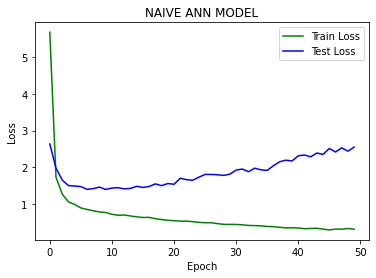

In [24]:
plot_losses(train_history=naive_train_loss,test_history=naive_test_loss,title='NAIVE ANN MODEL')

Clearly, we are overfitting. Overfitting starts very early epoch-wise.

Creating an accuracy function, 
the function will take in the model as input and then output the accuracy
that way I don't have to code the same stuff every time:

In [25]:
def take_model_give_acc(model,lstm_check=False):
    model.eval()
    rights,total=0,0
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        if lstm_check:
            ŷ=model(x)
        else:
            ŷ=model(x.float())
        z,preds=torch.max(ŷ,1)
        rights+=(preds==y).sum().item()
        total+=y.shape[0]
    training_accuracy=rights/total
    rights,total=0,0
    for x,y in test_loader:
        x,y,=x.to(device),y.to(device)
        if lstm_check:
            ŷ=model(x)
        else:
            ŷ=model(x.float())
        z,preds=torch.max(ŷ,1)
        rights+=(preds==y).sum().item()
        total+=y.shape[0]
    testing_accuracy=rights/total
    print(f'Train Accuracy: {training_accuracy}, Test Accuracy:{testing_accuracy}')
    
    
## using function
take_model_give_acc(trained_naive_model)

Train Accuracy: 0.9048682447521215, Test Accuracy:0.6696528555431132


Train accuracy is very high, but on the other hand test accuracy is very low. This suggests that we are over fitting to the 
Training data's noise. This is bad. We can see that overfitting also starts pretty early epoch-wise.

##### High train accuracy and low test accuracy, we are overfitting to the train noise. This is bad.

making a confusion matrix function to see what's going on


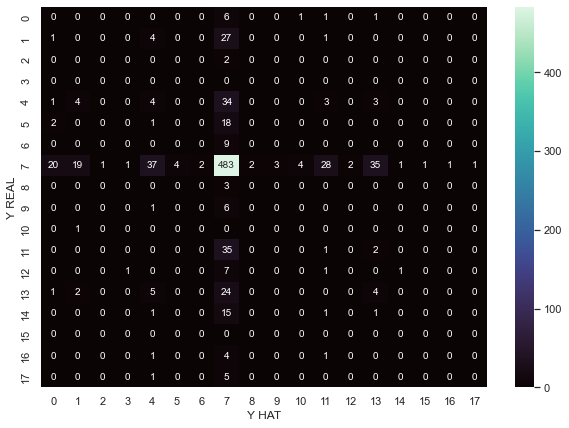

In [26]:
def take_model_give_matrix(model,lstm_check=False):
    X=testing_data_ready
    Y=np.array(TEST_DATA_FRAME['label_mapping'])
    labels=[x for x in range(18)]
    Y_PRED=np.array([])
    for x,y in test_loader:
        x,y=x.to(device),y.to(device)
        if lstm_check:
            ŷ=model(x)
        else:
            ŷ=model(x.float())
        Z,preds=torch.max(ŷ,1)
        Y_PRED=np.concatenate((Y_PRED,preds.cpu().numpy()))
    Y_PRED[:18]=[i for i in range(18)] # Note that this is done in order to create the confusion matrix correctly.
    cm=confusion_matrix(Y,Y_PRED)
    df_cm=pd.DataFrame(cm,labels,labels)
    plt.figure(figsize=(10,7))
    sn.color_palette("hls", 10)
    sn.set(font_scale=1)
    sn.heatmap(df_cm,annot=True,fmt='g',annot_kws={'size':10}, cmap="mako")
    plt.xlabel('Y HAT')
    plt.ylabel('Y REAL')
    plt.show()    
    return None

## let's get the confusion matrix:
take_model_give_matrix(model=trained_naive_model)

Bad diagonal, strong straight lines for the 'atis flight' label. This is bad, suggests model is gaming the system by mostly predicting atis flight all the time.

In [27]:
all_labels_mapping['atis_flight'] # the model mostly predicts "atis_flight" in order to "game the system."

7

We can see that the model is basically always saying atis_flights. Even though the test accuracy might look pretty high, this might not be the best model... maybe the data is imbalanced?
Let's investigate further using a histogram.


<AxesSubplot:title={'center':'HISTOGRAM OF LABELS'}>

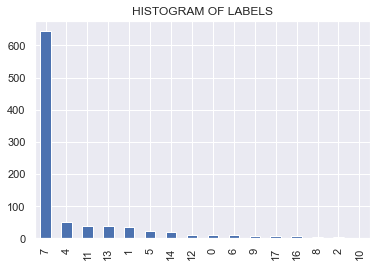

In [28]:
TEST_DATA_FRAME['label_mapping'].value_counts().plot(kind='bar',title='HISTOGRAM OF LABELS')

Indeed, The data is imbalanced.
we can see that the majority class is atis_flight. In other words, the model is almost always predicting atis_flight to "game the system".
Our Ideal model would predict the right label, and not always atis_flight.


$\blacksquare$

#### Creating an Intent Classification model that uses a Language Model. 


According to [Yu Wang, Yilin Shen & Hongxia Jin](https://arxiv.org/pdf/1812.10235v1.pdf) a BiDirectional LSTM Model achieved 
State of the art results on this dataset. I will not use their exact model. I will implement a more simple BiLSTM model to see 
the improvements.

In [29]:
## creating model:

class BLSTM(nn.Module):
    def __init__(self,vocabulary_size,embedding_dimension,lstm_hidden,lstm_layers,classes):
        super(BLSTM,self).__init__()
        self.Voc=vocabulary_size
        self.Embed=embedding_dimension
        self.HiddenUnits=lstm_hidden
        self.K=classes
        self.Layers=lstm_layers
        # Note the embedding layer, as this is a language model
        ## Note how I have to add +2 to self.Voc (because I use 0 for padding and 1 for unkown)
        self.embedding=nn.Embedding(self.Voc+2,self.Embed)
        self.lstm=nn.LSTM(input_size=self.Embed,hidden_size=self.HiddenUnits,
                          num_layers=self.Layers,batch_first=True,
                         bidirectional=True)
        self.fully_connected=nn.Linear(self.HiddenUnits * 2,self.K)
    
    def forward(self,x):
        h0=torch.zeros(self.Layers*2, x.size(0), self.HiddenUnits,device=device )
        c0=torch.zeros(self.Layers*2, x.size(0), self.HiddenUnits,device=device )
        
        output=self.embedding(x)
        
        output, _ = self.lstm(output,(h0,c0))
        output = self.fully_connected(output[:,-1,:]) ### get last hidden state
        return output

In [30]:
bidirectional_lstm_model=BLSTM(vocabulary_size=len(vocabulary_set),
                              embedding_dimension=20,
                              lstm_hidden=2,
                              lstm_layers=2,
                              classes=len(all_labels_mapping)).to(device)


criterion_BLSTM=nn.CrossEntropyLoss()
optimizer_BLSTM=torch.optim.Adam(bidirectional_lstm_model.parameters(),)
trained_lstm,lstm_train_loss,lstm_test_loss=training_function(model=bidirectional_lstm_model,
                                                    criterion=criterion_BLSTM,
                                                    optimizer=optimizer_BLSTM,
                                                    train_load=train_loader,
                                                    test_load=test_loader,
                                                    epochs=50,
                                                    lstm_check=True)

Epoch:10/50, TrainLoss:0.96573, TestLoss : 1.06554
Epoch:20/50, TrainLoss:0.61413, TestLoss : 0.81739
Epoch:30/50, TrainLoss:0.50451, TestLoss : 0.76783
Epoch:40/50, TrainLoss:0.42451, TestLoss : 0.74956
Epoch:50/50, TrainLoss:0.37456, TestLoss : 0.76108


##### Confusion Matrix:

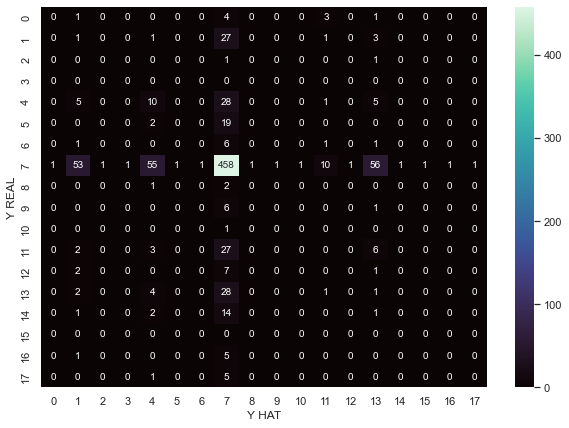

In [31]:
take_model_give_matrix(model=trained_lstm,lstm_check=True)

still bad diagonals, strong straight line predictions for majority label. bad.

##### Losses:

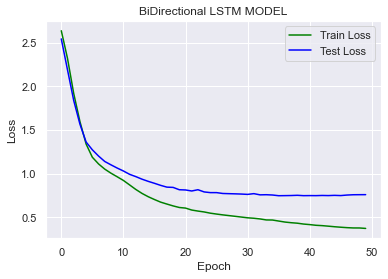

In [32]:
plot_losses(train_history=lstm_train_loss,test_history=lstm_test_loss,title='BiDirectional LSTM MODEL')

Overfitting seems less of a problem in this model when compared to the ANN model. maybe we could even train for more epochs.

##### Accuracies:

In [33]:
take_model_give_acc(model=trained_lstm,lstm_check=True)

Train Accuracy: 0.9064314426083073, Test Accuracy:0.8118701007838746


WOW!

With this model i'm getting high train accuracy and test accuracy. Specifically, i'm getting a very high increase in test accuracy using this model. Additionally, when inspecting the losses we can see that even after 50 epochs, there isn't really any significant overfitting.

We can clearly see the power of the Language model neural network, especially when inspecting the losses and the accuracy.
First of all, we can see that the accuracy on the test data increased. Additionally, we can see that there is a lot LESS overfitting to the 
train data noise, which is very good this means that the model is actually learning.

Still, we must not forget the bad diagonals in the confusion matrix, which suggests that the model predicts mostly the majority labels... in other words, the model found a way to "win" the game...

##### BERT

In this part I will try out the BERT transformer model. I will use the pretrained bert model provided by the transformers library and then
freeze the weights, add my own fully connected layers to train. Then I will make predictions etc using my functions. I will also need to do some different preprocessing on the data sets because bert has its own tokenizer which is easy to use.
I will use the Hugging face documentation to comeplete this task:
 [$I$](https://huggingface.co/docs/transformers/model_doc/bert), [$II$](https://huggingface.co/docs/transformers/training) 

In [34]:
from transformers import AutoConfig, AutoModel, BertTokenizerFast
import torch.nn.functional as F

In [35]:
BERT_MODEL=AutoModel.from_pretrained('bert-base-uncased')
BERT_TOKEN=BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# function that takes in a main data frame ( the ones in CAPSLOCK) and returns a dataloader ready to be used 
# for the bert model:
def Create_Bert_Dataloader(df):
    bert_data=(df['data']).tolist()
    bert_labels=torch.tensor(df['label_mapping'].tolist())
    bert_data_tokenized=BERT_TOKEN.batch_encode_plus(bert_data,max_length=maxlen,pad_to_max_length=True)
    bert_input_ids=torch.tensor(bert_data_tokenized['input_ids'])
    bert_attention_mask=torch.tensor(bert_data_tokenized['attention_mask'])
    bert_dataset=data_utils.TensorDataset(bert_input_ids,bert_attention_mask,bert_labels)
    bert_dataloader=data_utils.DataLoader(bert_dataset,batch_size=64)
    return bert_dataloader

In [37]:
## creating the dataloaders for train and test data...
BERT_TRAIN_DATALOADER=Create_Bert_Dataloader(TRAIN_DATA_FRAME)
BERT_TEST_DATALOADER=Create_Bert_Dataloader(TEST_DATA_FRAME)
#### freezing the parameters of the bert model.
for param in BERT_MODEL.parameters():
    param.requires_grad=False

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\yoel1\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [38]:
# Creating my bert model.
class Custom_Bert_Model(nn.Module):
    def __init__(self,BERT_Model):
        super(Custom_Bert_Model,self).__init__()
        self.frozen_bert=BERT_MODEL
        self.first_fully_connected=nn.Linear(768,256)
        self.second_fully_connected=nn.Linear(256,128)
        self.final_fully_connected=nn.Linear(128,len(all_labels_mapping))
        
    def forward(self,IDS,AM):
        ### IDS <----- input ids, AM<---- attention mask
        _, bert_out=self.frozen_bert(IDS,attention_mask=AM, return_dict=False)
        output=F.relu(self.first_fully_connected(bert_out))
        output=F.relu(self.second_fully_connected(output))
        output=self.final_fully_connected(output)
        return output

In [39]:
bert_model=Custom_Bert_Model(BERT_MODEL)
bert_model.to(device)

Custom_Bert_Model(
  (frozen_bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

Now that the model is ready, I basically have to rewrite the training function for the bert model.


##### Training Bert Model:

In [40]:
def bert_training_function(model,criterion,optimizer,train_load,test_load,epochs):
    train_loss_history=np.zeros(epochs) # loss per epoch
    test_loss_history=np.zeros(epochs) # loss per epoch
    for epoch in range(epochs):
        current_train_loss=[] # loss per batch
        for z,datum in enumerate(train_load):
            datum=[x.to(device) for x in datum]
            IDS,AM,y=datum
            optimizer.zero_grad()
            ŷ=model(IDS,AM)
            loss=criterion(ŷ,y) # Notice y hat and y :D
            loss.backward()
            optimizer.step()
            current_train_loss.append(loss.item())

        current_train_loss=np.mean(current_train_loss)
        train_loss_history[epoch]=current_train_loss


        current_test_loss=[]
        for z,datum in enumerate(test_load):
            datum=[x.to(device) for x in datum]
            IDS,AM,y=datum
            ŷ=model(IDS,AM)
            loss=criterion(ŷ,y)
            current_test_loss.append(loss.item())
        current_test_loss=np.mean(current_test_loss)

        test_loss_history[epoch]=current_test_loss
        if (epoch+1)%10==0:
            print(f'Epoch:{epoch+1}/{epochs}, TrainLoss:{current_train_loss:.5f}, TestLoss : {current_test_loss:.5f}')
    return model,train_loss_history,test_loss_history

In [41]:
criterion_BERT=nn.CrossEntropyLoss()
optimizer_BERT=torch.optim.Adam(bert_model.parameters(),)

In [42]:
trained_bert,bert_train_loss,bert_test_loss=bert_training_function(model=bert_model
                                                                   ,criterion=criterion_BERT
                                                                   ,optimizer=optimizer_BERT
                                                                   ,train_load=BERT_TRAIN_DATALOADER
                                                                   ,test_load=BERT_TEST_DATALOADER
                                                                   ,epochs=50)

Epoch:10/50, TrainLoss:0.50601, TestLoss : 0.67467
Epoch:20/50, TrainLoss:0.36864, TestLoss : 0.54065
Epoch:30/50, TrainLoss:0.30129, TestLoss : 0.50698
Epoch:40/50, TrainLoss:0.23727, TestLoss : 0.64248
Epoch:50/50, TrainLoss:0.19906, TestLoss : 0.48584


##### Bert Confusion Matrix

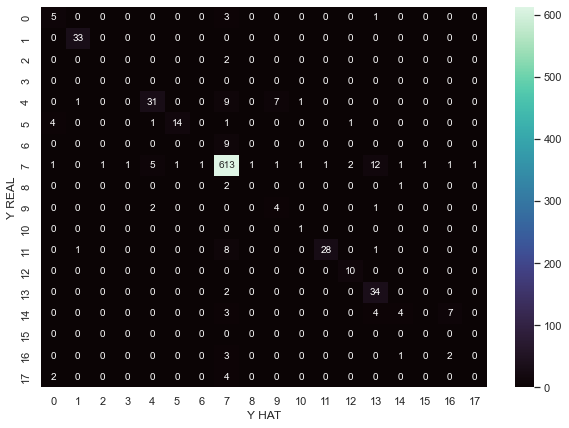

In [43]:
def bert_confusion_matrix(model):
    X=testing_data_ready
    Y=np.array(TEST_DATA_FRAME['label_mapping'])
    labels=[x for x in range(18)]
    Y_PRED=np.array([])
    for z,datum in enumerate(BERT_TEST_DATALOADER):
        datum=[x.to(device) for x in datum]
        IDS,AM,y=datum
        ŷ=model(IDS,AM)
        Z,preds=torch.max(ŷ,1)
        Y_PRED=np.concatenate((Y_PRED,preds.cpu().numpy()))
    Y_PRED[:18]=[i for i in range(18)] # Note that this is done in order to create the confusion matrix correctly.
    cm=confusion_matrix(Y,Y_PRED)
    df_cm=pd.DataFrame(cm,labels,labels)
    plt.figure(figsize=(10,7))
    sn.color_palette("hls", 10)
    sn.set(font_scale=1)
    sn.heatmap(df_cm,annot=True,fmt='g',annot_kws={'size':10}, cmap="mako")
    plt.xlabel('Y HAT')
    plt.ylabel('Y REAL')
    plt.show()    
    return None
bert_confusion_matrix(model=trained_bert)

This model has the Best diagonal, notice the difference between BERT's confusion matrix and the two prior models above,
it seems like this model ACTUALLY learned to predict correctly.

##### Losses

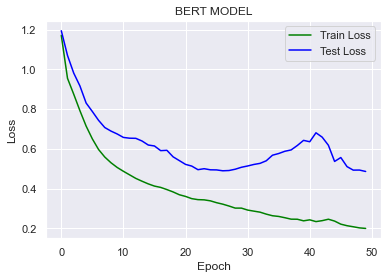

In [44]:
plot_losses(bert_train_loss,bert_test_loss,title='BERT MODEL')

Looks good, seems like we could even train for more epochs. (maybe the model escaped a local minimum after around epoch 40)

##### Accuracies

In [45]:
def bert_accuracy(model):
    model.eval()
    rights,total=0,0
    for z,datum in enumerate(BERT_TRAIN_DATALOADER):
        datum=[x.to(device) for x in datum]
        IDS,AM,y=datum
        ŷ=model(IDS,AM)
        z,preds=torch.max(ŷ,1)
        rights+=(preds==y).sum().item()
        total+=y.shape[0]
    training_accuracy=rights/total
    rights,total=0,0
    for z,datum in enumerate(BERT_TEST_DATALOADER):
        datum=[x.to(device) for x in datum]
        IDS,AM,y=datum
        ŷ=model(IDS,AM)
        z,preds=torch.max(ŷ,1)
        rights+=(preds==y).sum().item()
        total+=y.shape[0]
    testing_accuracy=rights/total
    print(f'Train Accuracy: {training_accuracy}, Test Accuracy:{testing_accuracy}')

In [46]:
bert_accuracy(trained_bert)

Train Accuracy: 0.9399285395265744, Test Accuracy:0.8902575587905935


BERT gives the best training accuracy and testing accuracy, which is very good. This model actually got a lot better.

### WOW

All in all, the BERT model did better than the Artificial neural network and the bidirectional lstm models.
Both in terms of losses and accuracies. For the same number of epochs I got the best metrics from the BERT Model. 
Bert got highest the best accuracies, and did not seem to overfit(like the ANN). 
It is also important to notice that the diagonal of BERT's confusion matrix is the best on out of three models. Bert's confusion matrix suggests that the model actually learned to predict correctly, and not only to predict the majority class.
All in all I declare BERT to be the best model!

$\blacksquare$